In [34]:
!pip list | grep "torch\|tensorflow\|transformers\|opencv\|scikit-learn"

opencv-contrib-python              4.11.0.86
opencv-python                      4.11.0.86
opencv-python-headless             4.11.0.86
pytorch-ignite                     0.5.2
pytorch-lightning                  2.5.1.post0
scikit-learn                       1.2.2
scikit-learn-intelex               2025.5.0
sentence-transformers              3.4.1
tensorflow                         2.18.0
tensorflow-cloud                   0.1.5
tensorflow-datasets                4.9.8
tensorflow_decision_forests        1.11.0
tensorflow-hub                     0.16.1
tensorflow-io                      0.37.1
tensorflow-io-gcs-filesystem       0.37.1
tensorflow-metadata                1.17.0
tensorflow-probability             0.25.0
tensorflow-text                    2.18.1
torch                              2.6.0+cu124
torchao                            0.10.0
torchaudio                         2.6.0+cu124
torchdata                          0.11.0
torchinfo                          1.8.0
torchmetrics  

In [35]:
!apt-get update
!apt-get install -y fonts-noto

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease                          
Hit:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease                                          
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease                                              
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease         
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease                   
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jamm

In [36]:
!pip install torch torchvision transformers opencv-python scikit-learn pillow-avif-plugin
 

In [37]:
import os
from gensim.models import KeyedVectors

# Check if the file already exists
if not os.path.exists('cc.bn.300.vec'):
    print("Downloading Bangla FastText vectors...")
    !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bn.300.vec.gz
    print("Extracting...")
    !gunzip cc.bn.300.vec.gz
    print("Download and extraction completed.")
else:
    print("FastText vectors already exist. Skipping download.")

# Load the FastText model
print("Loading FastText model...")
ft_model = KeyedVectors.load_word2vec_format('cc.bn.300.vec', binary=False)
print("FastText model loaded successfully!")


--2025-05-30 18:16:18--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bn.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.33, 3.171.22.118, 3.171.22.68, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 881274182 (840M) [binary/octet-stream]
Saving to: ‘cc.bn.300.vec.gz’

cc.bn.300.vec.gz    100%[===================>] 840.45M   287MB/s    in 2.9s    

2025-05-30 18:16:21 (287 MB/s) - ‘cc.bn.300.vec.gz’ saved [881274182/881274182]

Extracting...
Download and extraction completed.
Loading FastText model...
FastText model loaded successfully!


In [38]:
import pandas as pd

# Load the CSV file
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTyh006zrmSWoKAwqF92kZ4lvNRKsZL5NYIkdSEK3wtrWA8yMKLT6K3h1k1nyyHjG9ntZvc9tTcbUif/pub?output=csv'
df = pd.read_csv(url,encoding="utf-8")
df.head()

,id,caption,label,level,area,Unnamed: 5
0,1,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
1,2,গোমতী নদীর পানি উত্তর পাশে পালপাড়া অংশে বাঁধ থ...,flood,1.0,NaN,NaN
2,3,কুমিল্লা,flood,1.0,কুমিল্লা,NaN
3,4,আখাউড়া উপজেলা ও কসবা উপজেলা'র বিভিন্ন এলাকায় ই...,flood,1.0,আখাউড়া,NaN
4,5,ফেনীর মুহুরী নদীতে পানির মাত্রা গত ৪০ বছরের ইত...,flood,1.0,ফেনী,NaN


In [39]:
# Cell 2: Import libraries
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from torchvision import models, transforms
from PIL import Image
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
# Drop unnecessary columns and handle missing values
columns_to_drop = [col for col in ['label', 'Unnamed: 5', 'area'] if col in df.columns]
df = df.drop(columns_to_drop, axis=1)
df = df.dropna(subset=['level'])
df['level'] = df['level'].astype(int)  # Ensure labels are integers
print("Label distribution:", df['level'].value_counts())

Label distribution: level
1    2660
0    2519
Name: count, dtype: int64


In [41]:
# Identify ID column
id_column = None
for col in df.columns:
    if col.lower() in [' id', 'identifier', 'image_id', 'id ']:
        id_column = col
        break
if id_column is None:
    raise KeyError("No 'id' column found in the DataFrame. Available columns: " + str(df.columns.tolist()))
print(f"Using ID column: {id_column}")

# Filter dataset for valid images
image_dir = '/kaggle/input/mddb-images/Photos_Final'
valid_extensions = ['.jpg', '.jpeg', '.png', '.avif']

available_images = []
for filename in os.listdir(image_dir):
    if any(filename.lower().endswith(ext) for ext in valid_extensions):
        try:
            img_id = int(os.path.splitext(filename)[0])
            available_images.append(img_id)
        except ValueError:
            continue

print(f"Found {len(available_images)} images")
df_filtered = df[df[id_column].isin(available_images)]
print(f"Original rows: {len(df)}, Filtered rows: {len(df_filtered)}")
if len(df_filtered) == 0:
    raise ValueError("No rows match available images. Check ID column or image files.")
df = df_filtered

Using ID column:  id
Found 5183 images
Original rows: 5179, Filtered rows: 5179


In [42]:
# Shuffle and split dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Fixed shuffle
train_ratio, val_ratio, test_ratio = 0.6, 0.2, 0.2
train_data, val_test = train_test_split(df, train_size=train_ratio, random_state=42)
valid_data, test_data = train_test_split(val_test, train_size=val_ratio/(val_ratio + test_ratio), random_state=42)

In [43]:
# Strip column names
train_data.columns = train_data.columns.str.strip()
valid_data.columns = valid_data.columns.str.strip()
test_data.columns = test_data.columns.str.strip()

In [44]:
# # Define text feature extraction (BanglaBERT)
# def get_text_features(data, model_name='sagorsarker/bangla-bert-base', max_length=128, batch_size=8):
#     try:
#         tokenizer = BertTokenizer.from_pretrained(model_name)
#         model = BertModel.from_pretrained(model_name)
#         if torch.cuda.is_available():
#             model = model.cuda()
#         model.eval()
        
#         texts = data['caption'].tolist()
#         features = []
        
#         for i in range(0, len(texts), batch_size):
#             batch_texts = texts[i:i+batch_size]
#             inputs = tokenizer(batch_texts, return_tensors='pt', max_length=max_length, truncation=True, padding=True)
#             inputs = {k: v.to(model.device) for k, v in inputs.items()}
            
#             with torch.no_grad():
#                 outputs = model(**inputs)
#                 batch_features = outputs.pooler_output.cpu().numpy()  # [CLS] token embeddings
#             features.append(batch_features)
        
#         return np.vstack(features)
#     except Exception as e:
#         print(f"Error in text feature extraction: {e}")
#         return np.zeros((len(data), 768))

In [45]:
# import numpy as np
# from gensim.models import KeyedVectors

# def get_text_features(data, ft_model):
#     try:
#         features = []
#         for caption in data['caption'].tolist():
#             tokens = caption.split()[:20]  # optional: truncate to first 20 tokens
#             vecs = [ft_model[word] for word in tokens if word in ft_model]
#             if vecs:
#                 avg_vec = np.mean(vecs, axis=0)
#             else:
#                 avg_vec = np.zeros(ft_model.vector_size)
#             features.append(avg_vec)
#         return np.vstack(features)
#     except Exception as e:
#         print(f"Error in FastText feature extraction: {e}")
#         return np.zeros((len(data), ft_model.vector_size))  # default FastText vector size



In [46]:
# # 🟢 1. Fit vectorizer on train data only
# from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf_max_features = 5000  # can adjust
# vectorizer = TfidfVectorizer(max_features=tfidf_max_features)

# # 🟢 2. Fit only on train data
# train_text_features = vectorizer.fit_transform(train_data['caption'].tolist()).toarray()

# # 🟢 3. Use transform on valid/test (re-use the same vectorizer!)
# valid_text_features = vectorizer.transform(valid_data['caption'].tolist()).toarray()
# test_text_features = vectorizer.transform(test_data['caption'].tolist()).toarray()


In [47]:
#Word to vec
def get_text_features(data, w2v_model):
    try:
        features = []
        for caption in data['caption'].tolist():
            tokens = caption.split()[:20]
            vecs = [w2v_model[word] for word in tokens if word in w2v_model]
            if vecs:
                avg_vec = np.mean(vecs, axis=0)
            else:
                avg_vec = np.zeros(w2v_model.vector_size)
            features.append(avg_vec)
        return np.vstack(features)
    except Exception as e:
        print(f"Error in Word2Vec feature extraction: {e}")
        return np.zeros((len(data), w2v_model.vector_size))


In [48]:
# Define image feature extraction (MobileNetV3)
def get_image_features(data, image_dir='/kaggle/input/mddb-images/Photos_Final', model_name='mobilenet_v3_small'):
    try:
        model = models.mobilenet_v3_small(weights='IMAGENET1K_V1')
        model.eval()
        if torch.cuda.is_available():
            model = model.cuda()
        
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        features = []
        missing_images = []
        valid_extensions = ['.jpg', '.jpeg', '.png', '.avif']
        
        for idx, row in data.iterrows():
            img_found = False
            for ext in valid_extensions:
                img_path = os.path.join(image_dir, f"{row['id']}{ext}")
                try:
                    img = Image.open(img_path).convert('RGB')
                    img_t = transform(img).unsqueeze(0)
                    if torch.cuda.is_available():
                        img_t = img_t.cuda()
                    with torch.no_grad():
                        feat = model(img_t).cpu().numpy().flatten()
                    features.append(feat)
                    img_found = True
                    break
                except Exception as e:
                    continue
            if not img_found:
                missing_images.append(row['id'])
                features.append(np.zeros(1000))  # Placeholder for missing image
        
        # Impute missing features with mean of available features
        if missing_images:
            valid_features = [f for f, m in zip(features, [i in missing_images for i in data['id']]) if not m]
            if valid_features:
                mean_features = np.mean(valid_features, axis=0)
                for i, idx in enumerate(data['id']):
                    if idx in missing_images:
                        features[i] = mean_features
        
        print(f"Processed {len(data)} images, Missing: {len(missing_images)} ({len(missing_images)/len(data)*100:.2f}%)")
        return np.vstack(features), missing_images
    except Exception as e:
        print(f"Error in image feature extraction: {e}")
        return np.zeros((len(data), 1000)), data['id'].tolist()

In [49]:
from gensim.models import KeyedVectors

# Load the FastText model
ft_model = KeyedVectors.load_word2vec_format('cc.bn.300.vec', binary=False)

# Extract features
train_text_features = get_text_features(train_data, ft_model)
valid_text_features = get_text_features(valid_data, ft_model)
test_text_features = get_text_features(test_data, ft_model)

# train_text_features = get_text_features(train_data, tfidf_max_features=1000)
# valid_text_features = get_text_features(valid_data, tfidf_max_features=1000)
# test_text_features = get_text_features(test_data, tfidf_max_features=1000)


In [50]:


train_image_features, train_missing = get_image_features(train_data, image_dir)
valid_image_features, valid_missing = get_image_features(valid_data, image_dir)
test_image_features, test_missing = get_image_features(test_data, image_dir)

# Combine features
train_features = np.hstack([train_text_features, train_image_features])
valid_features = np.hstack([valid_text_features, valid_image_features])
test_features = np.hstack([test_text_features, test_image_features])

train_labels = train_data['level'].values
valid_labels = valid_data['level'].values
test_labels = test_data['level'].values

# Scale features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
valid_features_scaled = scaler.transform(valid_features)
test_features_scaled = scaler.transform(test_features)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 95.0MB/s]


Processed 3107 images, Missing: 0 (0.00%)
Processed 1036 images, Missing: 0 (0.00%)
Processed 1036 images, Missing: 0 (0.00%)


In [51]:
# Train XGBoost model without showing validation and logloss
# xgb_model = XGBClassifier(
#     n_estimators=1000,       # Keep higher number of trees
#     learning_rate=0.01,      # Low learning rate (stable)
#     max_depth=3,             # Shallower trees for less complexity
#     reg_lambda=10,           # Stronger L2 regularization
#     reg_alpha=2,             # Stronger L1 regularization
#     subsample=0.6,           # Lower subsample for more randomness
#     colsample_bytree=0.6,    # Lower colsample for more randomness
#     gamma=0.3,               # Increase gamma to control tree split
#     random_state=42,
#     n_jobs=-1,
#     eval_metric='logloss'
# )

xgb_model = XGBClassifier(
    n_estimators=800,        # Fewer trees
    learning_rate=0.01,      # Low learning rate
    max_depth=2,             # Even shallower trees
    reg_lambda=15,           # Even stronger L2 regularization
    reg_alpha=3,             # Even stronger L1 regularization
    subsample=0.5,           # Lower subsample
    colsample_bytree=0.5,    # Lower colsample
    gamma=0.5,               # Increased gamma
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss'
)


try:
    xgb_model.fit(
        train_features_scaled, train_labels,
        eval_set=[(train_features_scaled, train_labels), (valid_features_scaled, valid_labels)],
        early_stopping_rounds=15,
        verbose=False  # Turn off logging
    )
except Exception as e:
    print(f"Error in XGBoost training: {e}")


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [52]:
# Evaluate model
try:
    # Training
    train_preds = xgb_model.predict(train_features_scaled)
    train_acc = accuracy_score(train_labels, train_preds)
    print(f"\nXGBoost Training Accuracy: {train_acc * 100:.2f}%")

    # Validation
    valid_preds = xgb_model.predict(valid_features_scaled)
    valid_acc = accuracy_score(valid_labels, valid_preds)
    print(f"XGBoost Validation Accuracy: {valid_acc * 100:.2f}%")
    print(f"Gap (train - valid): {(train_acc - valid_acc) * 100:.2f}%")
    print("\nValidation Classification Report:\n", classification_report(valid_labels, valid_preds, target_names=['Non Informative', 'Informative']))

    # Test
    test_preds = xgb_model.predict(test_features_scaled)
    test_acc = accuracy_score(test_labels, test_preds)
    print(f"\nXGBoost Test Accuracy: {test_acc * 100:.2f}%")
    print("\nTest Classification Report:\n", classification_report(test_labels, test_preds, target_names=['Non Informative', 'Informative']))

    # Confusion matrix
    cm = confusion_matrix(test_labels, test_preds)
    print("\nConfusion Matrix:\n", cm)
except Exception as e:
    print(f"Error in model evaluation: {e}")


XGBoost Training Accuracy: 96.59%
XGBoost Validation Accuracy: 96.14%
Gap (train - valid): 0.45%

Validation Classification Report:
                  precision    recall  f1-score   support

Non Informative       0.96      0.96      0.96       512
    Informative       0.97      0.96      0.96       524

       accuracy                           0.96      1036
      macro avg       0.96      0.96      0.96      1036
   weighted avg       0.96      0.96      0.96      1036


XGBoost Test Accuracy: 95.56%

Test Classification Report:
                  precision    recall  f1-score   support

Non Informative       0.95      0.96      0.96       510
    Informative       0.97      0.95      0.96       526

       accuracy                           0.96      1036
      macro avg       0.96      0.96      0.96      1036
   weighted avg       0.96      0.96      0.96      1036


Confusion Matrix:
 [[492  18]
 [ 28 498]]


In [53]:
print(xgb_model.evals_result_.keys())


dict_keys(['validation_0', 'validation_1'])


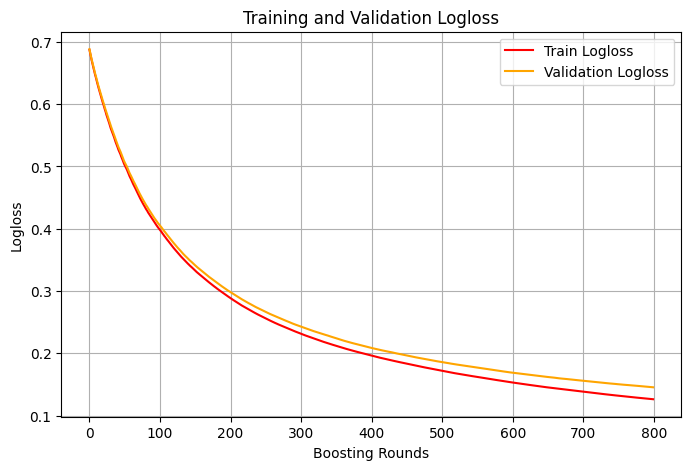

In [54]:
results = xgb_model.evals_result_
train_logloss = results['validation_0']['logloss']
valid_logloss = results['validation_1']['logloss']

plt.figure(figsize=(8,5))
plt.plot(train_logloss, label='Train Logloss', color='red')
plt.plot(valid_logloss, label='Validation Logloss', color='orange')
plt.xlabel('Boosting Rounds')
plt.ylabel('Logloss')
plt.title('Training and Validation Logloss')
plt.legend()
plt.grid(True)
plt.show()


<Figure size 1000x600 with 0 Axes>

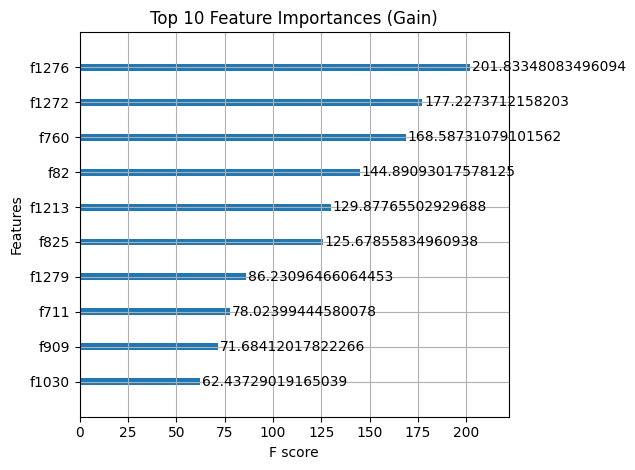

In [55]:
# Cell 10: Plot feature importance
plt.figure(figsize=(10, 6))
plot_importance(xgb_model, max_num_features=10, importance_type='gain')
plt.title("Top 10 Feature Importances (Gain)")
plt.tight_layout()
plt.show()

In [56]:
# Cell 10: Cross-validation
xgb_cv_scores = cross_val_score(xgb_model, train_features_scaled, train_labels, cv=5, scoring='accuracy', n_jobs=-1)
print("XGBoost 5-Fold CV Accuracy:", xgb_cv_scores)
print("Mean CV Accuracy:", np.mean(xgb_cv_scores))

XGBoost 5-Fold CV Accuracy: [0.95498392 0.94212219 0.95008052 0.94847021 0.93397746]
Mean CV Accuracy: 0.9459268579358051


In [57]:
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

# # # BanglaBERT parameters
# # text_model = BertModel.from_pretrained('sagorsarker/bangla-bert-base')
# # print("BanglaBERT Parameters:", count_parameters(text_model))

# # FastText info
# ft_model = KeyedVectors.load_word2vec_format('cc.bn.300.vec')  # path to your FastText model
# print("FastText Embedding Dimension:", ft_model.vector_size)
# print("FastText Vocabulary Size:", len(ft_model.key_to_index))

# # Word2Vec info
# # For example, if you have a Word2Vec model loaded:
# # w2v_model = KeyedVectors.load_word2vec_format('path_to_word2vec')
# # print("Word2Vec Embedding Dimension:", w2v_model.vector_size)
# # print("Word2Vec Vocabulary Size:", len(w2v_model.key_to_index))

# # TF-IDF info
# # For example, if you used sklearn's TfidfVectorizer:
# # tfidf_vectorizer = TfidfVectorizer()
# # tfidf_vectorizer.fit(your_corpus)
# # print("TF-IDF Vocabulary Size:", len(tfidf_vectorizer.vocabulary_))

# # Vision model
# vision_model = models.mobilenet_v3_small(pretrained=True)
# print("MobileNetV3-Small Parameters:", count_parameters(vision_model))

# # XGBoost
# print("XGBoost Trees:", xgb_model.n_estimators)
# print("XGBoost Total Nodes:", sum(len(tree.split('\n')) for tree in xgb_model.get_booster().get_dump()))


In [58]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# # BanglaBERT parameters
# text_model = BertModel.from_pretrained('sagorsarker/bangla-bert-base')
# print("BanglaBERT Parameters:", count_parameters(text_model))

# # FastText info
# ft_model = KeyedVectors.load_word2vec_format('cc.bn.300.vec')  # path to your FastText model
# print("FastText Embedding Dimension:", ft_model.vector_size)
# print("FastText Vocabulary Size:", len(ft_model.key_to_index))

# Word2Vec info
# For example, if you have a Word2Vec model loaded:
# Load the Word2Vec model
w2v_model = KeyedVectors.load_word2vec_format('path_to_word2vec', binary=True)
print("Word2Vec Embedding Dimension:", w2v_model.vector_size)
print("Word2Vec Vocabulary Size:", len(w2v_model.key_to_index))

# #TF-IDF info
# #For example, if you used sklearn's TfidfVectorizer:
# tfidf_vectorizer = TfidfVectorizer()
# corpus = train_data['caption'].tolist()
# tfidf_vectorizer.fit(corpus)
# print("TF-IDF Vocabulary Size:", len(tfidf_vectorizer.vocabulary_))

# Vision model
vision_model = models.mobilenet_v3_small(pretrained=True)
print("MobileNetV3-Small Parameters:", count_parameters(vision_model))

# XGBoost
print("XGBoost Trees:", xgb_model.n_estimators)
print("XGBoost Total Nodes:", sum(len(tree.split('\n')) for tree in xgb_model.get_booster().get_dump()))


FileNotFoundError: [Errno 2] No such file or directory: 'path_to_word2vec'

In [ ]:
# Cell 12: Save model and predictions
xgb_model.save_model('xgboost_model.json')
test_data['predicted_level'] = test_preds
test_data[['id', 'predicted_level']].to_csv('submission.csv', index=False)